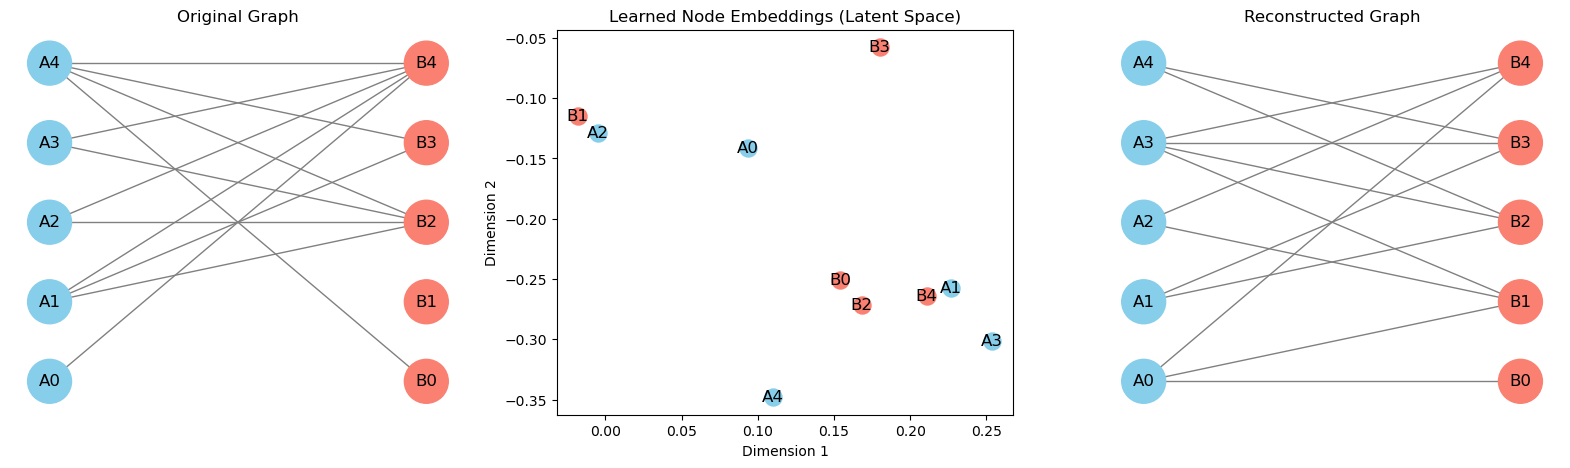

[['0' 'A0' 'B0']
 ['0' 'A0' 'B1']
 ['0' 'A0' 'B2']
 ['0' 'A0' 'B3']
 ['1' 'A0' 'B4']
 ['0' 'A1' 'B0']
 ['0' 'A1' 'B1']
 ['1' 'A1' 'B2']
 ['1' 'A1' 'B3']
 ['1' 'A1' 'B4']
 ['0' 'A2' 'B0']
 ['0' 'A2' 'B1']
 ['1' 'A2' 'B2']
 ['0' 'A2' 'B3']
 ['1' 'A2' 'B4']
 ['0' 'A3' 'B0']
 ['0' 'A3' 'B1']
 ['1' 'A3' 'B2']
 ['0' 'A3' 'B3']
 ['1' 'A3' 'B4']
 ['1' 'A4' 'B0']
 ['0' 'A4' 'B1']
 ['1' 'A4' 'B2']
 ['1' 'A4' 'B3']
 ['1' 'A4' 'B4']]


In [21]:
# Re-import necessary libraries after execution reset
import random
import networkx as nx
import numpy as np
import matplotlib.pyplot as plt
from gensim.models import Word2Vec
from sklearn.metrics.pairwise import euclidean_distances
import torch

# ----------------------------
# Step 1: Create a Bipartite Graph
# ----------------------------
num_nodes_set_1 = 5  # Left column
num_nodes_set_2 = 5  # Right column

nodes_set_1 = [f"A{i}" for i in range(num_nodes_set_1)]
nodes_set_2 = [f"B{i}" for i in range(num_nodes_set_2)]
all_nodes = nodes_set_1 + nodes_set_2

random.seed(99)

G = nx.Graph()
G.add_nodes_from(nodes_set_1, bipartite=0)
G.add_nodes_from(nodes_set_2, bipartite=1)

edges = []
for u in nodes_set_1:
    for v in nodes_set_2:
        if random.random() > 0.5:  # 50% chance of an edge
            G.add_edge(u, v)
            edges.append((u, v))

# ----------------------------
# Step 2: Generate Random Walks for Embedding
# ----------------------------
def generate_metapath_walks(G, nodes, walk_length=10, num_walks=10):
    """Generate metapath2vec-style random walks (bipartite alternating)."""
    walks = []
    for _ in range(num_walks):
        for start in nodes:
            walk = [start]
            current = start
            for _ in range(walk_length - 1):
                neighbors = list(G.neighbors(current))
                if not neighbors:
                    break
                if current in nodes_set_1:
                    valid_neighbors = [n for n in neighbors if n in nodes_set_2]
                else:
                    valid_neighbors = [n for n in neighbors if n in nodes_set_1]
                if not valid_neighbors:
                    break
                current = random.choice(valid_neighbors)
                walk.append(current)
            walks.append(walk)
    return walks

walks = generate_metapath_walks(G, all_nodes, walk_length=5, num_walks=10)

# ----------------------------
# Step 3: Train Word2Vec Embeddings
# ----------------------------
embedding_dim = 8
model = Word2Vec(walks, vector_size=embedding_dim, window=3, min_count=0, sg=1, workers=1, epochs=100)
embeddings = {node: model.wv[node] for node in all_nodes}
emb_matrix = torch.tensor(np.array([embeddings[node] for node in all_nodes]), dtype=torch.float)

# ----------------------------
# Step 4: Compute Probabilistic Edge Likelihood
# ----------------------------
def edge_probability(z_i, z_j, alpha=1.0):
    """Compute the probability of an edge given embeddings."""
    dist = np.linalg.norm(z_i - z_j) ** 2  # Squared Euclidean distance
    return 1 / (1 + np.exp(alpha * dist))  # Logistic function

# ----------------------------
# Step 5: Reconstruct a New Bipartite Graph Using Probabilities
# ----------------------------
new_G = nx.Graph()
new_G.add_nodes_from(nodes_set_1, bipartite=0)
new_G.add_nodes_from(nodes_set_2, bipartite=1)

alpha = 0.5  # Scaling factor for probability (tuneable)

for u in nodes_set_1:
    for v in nodes_set_2:
        prob = edge_probability(embeddings[u], embeddings[v], alpha)
        if random.random() < prob:  # Sample based on probability
            new_G.add_edge(u, v)

# ----------------------------
# Step 6: Visualize Original and Reconstructed Graphs
# ----------------------------
fig, axes = plt.subplots(1, 3, figsize=(20, 5))
pos = {node: (0, i) for i, node in enumerate(nodes_set_1)}
pos.update({node: (1, i) for i, node in enumerate(nodes_set_2)})

# Plot Original Graph
nx.draw(G, pos, with_labels=True, node_size=1000, node_color=['skyblue' if n in nodes_set_1 else 'salmon' for n in G.nodes()], edge_color="gray", ax=axes[0])
axes[0].set_title("Original Graph")

# Plot Embeddings
emb_array = emb_matrix.detach().numpy()
for idx, node in enumerate(all_nodes):
    color = 'skyblue' if node in nodes_set_1 else 'salmon'
    axes[1].scatter(emb_array[idx, 0], emb_array[idx, 1], c=color, s=150)
    axes[1].text(emb_array[idx, 0], emb_array[idx, 1], node, fontsize=12, ha='center', va='center')
axes[1].set_title("Learned Node Embeddings (Latent Space)")
axes[1].set_xlabel("Dimension 1")
axes[1].set_ylabel("Dimension 2")

# Plot Reconstructed Graph
nx.draw(new_G, pos, with_labels=True, node_size=1000, node_color=['skyblue' if n in nodes_set_1 else 'salmon' for n in G.nodes()], edge_color="gray", ax=axes[2])
axes[2].set_title("Reconstructed Graph")


plt.show()

# ----------------------------
# Step 7: Create Data Matrix
# ----------------------------
data_matrix = []

for u in nodes_set_1:
    for v in nodes_set_2:
        edge_exists = 1 if G.has_edge(u, v) else 0
        data_matrix.append([edge_exists, u, v])

# Convert to numpy array for easier manipulation
data_matrix = np.array(data_matrix)

# Display the data matrix
print(data_matrix)



In [22]:
data_matrix

array([['0', 'A0', 'B0'],
       ['0', 'A0', 'B1'],
       ['0', 'A0', 'B2'],
       ['0', 'A0', 'B3'],
       ['1', 'A0', 'B4'],
       ['0', 'A1', 'B0'],
       ['0', 'A1', 'B1'],
       ['1', 'A1', 'B2'],
       ['1', 'A1', 'B3'],
       ['1', 'A1', 'B4'],
       ['0', 'A2', 'B0'],
       ['0', 'A2', 'B1'],
       ['1', 'A2', 'B2'],
       ['0', 'A2', 'B3'],
       ['1', 'A2', 'B4'],
       ['0', 'A3', 'B0'],
       ['0', 'A3', 'B1'],
       ['1', 'A3', 'B2'],
       ['0', 'A3', 'B3'],
       ['1', 'A3', 'B4'],
       ['1', 'A4', 'B0'],
       ['0', 'A4', 'B1'],
       ['1', 'A4', 'B2'],
       ['1', 'A4', 'B3'],
       ['1', 'A4', 'B4']], dtype='<U21')

In [7]:
def loss(embedding, data):
    total_loss = 0.0
    for edge_exists, u, v in data:
        edge_exists = int(edge_exists)
        z_u = embedding[u]
        z_v = embedding[v]
        prob = edge_probability(z_u, z_v, alpha)
        total_loss += edge_exists * np.log(prob) + (1 - edge_exists) * np.log(1 - prob)
    return -total_loss / len(data)

loss(embeddings, data_matrix)

0.663737890797826

In [11]:
embeddings["A0"], embeddings["B0"]


(array([ 0.09336594, -0.14133762, -0.30241957,  0.2901388 , -0.43457967,
         0.12654728,  0.09402349,  0.3778647 ], dtype=float32),
 array([ 0.15388569, -0.2508522 , -0.3052203 ,  0.3531456 , -0.40000814,
         0.08103395, -0.045482  ,  0.12915936], dtype=float32))

In [ ]:
nodes_set_1[1]

'A'